# Imports/Setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path

%matplotlib inline

dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

conn = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(os.getenv('DB_USER'),
                                                               os.getenv('DB_PASS'), 
                                                               os.getenv('DB_IP'), 
                                                               os.getenv('DB_PORT'), 
                                                               os.getenv('DB_NAME')))

# Download/Setup Data

In [3]:
dreampop_data = pd.read_sql("SELECT * FROM dreampop;", conn)
other_data = pd.read_sql("SELECT * FROM other;", conn)

In [4]:
#Combine data, drop non needed cols
data = dreampop_data.append(other_data, ignore_index=True)
data = data.drop(['index', 'type', 'uri', 'track_href', 'analysis_url'], axis=1)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre
0,0.420,0.330,9,-13.925,1,0.0275,0.24500,0.000679,0.0677,0.1750,157.143,1LzNfuep1bnAUR9skqdHCK,295600,3,Fade Into You,Mazzy Star,dreampop
1,0.512,0.838,0,-6.842,1,0.0310,0.01180,0.014200,0.1160,0.1950,117.992,1bwqV8EGVw1RLT3cEzxLpH,203390,4,Closer,Josha Daniel,dreampop
2,0.347,0.550,7,-9.048,1,0.0399,0.00419,0.049200,0.0992,0.0669,124.867,5TRSyGcFfevCbJHFUk4OB0,199680,4,Alive,Josha Daniel,dreampop
3,0.377,0.650,2,-5.902,1,0.0290,0.00174,0.000058,0.1070,0.3650,180.074,6sVQNUvcVFTXvlk3ec0ngd,192467,4,Cherry-coloured Funk,Cocteau Twins,dreampop
4,0.638,0.761,4,-7.945,0,0.1690,0.14700,0.000217,0.3210,0.3780,119.987,4uXWLG0CBQhJlvqPksiHxu,188000,4,High Enough,Lodola,dreampop


In [5]:
#Create genre ids
genres = list(data.groupby('genre').count().index)
genre_to_id = {}
id_to_genre = {}
for i, g in enumerate(genres):
    genre_to_id[g] = i
    genre_to_id[i] = g

In [6]:
#Map genres
data['genre_id'] = data['genre'].apply(lambda x: genre_to_id[x])
data['is_dreampop'] = data['genre'].apply(lambda x: True if x == 'dreampop' else False)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre,genre_id,is_dreampop
0,0.420,0.330,9,-13.925,1,0.0275,0.24500,0.000679,0.0677,0.1750,157.143,1LzNfuep1bnAUR9skqdHCK,295600,3,Fade Into You,Mazzy Star,dreampop,28,True
1,0.512,0.838,0,-6.842,1,0.0310,0.01180,0.014200,0.1160,0.1950,117.992,1bwqV8EGVw1RLT3cEzxLpH,203390,4,Closer,Josha Daniel,dreampop,28,True
2,0.347,0.550,7,-9.048,1,0.0399,0.00419,0.049200,0.0992,0.0669,124.867,5TRSyGcFfevCbJHFUk4OB0,199680,4,Alive,Josha Daniel,dreampop,28,True
3,0.377,0.650,2,-5.902,1,0.0290,0.00174,0.000058,0.1070,0.3650,180.074,6sVQNUvcVFTXvlk3ec0ngd,192467,4,Cherry-coloured Funk,Cocteau Twins,dreampop,28,True
4,0.638,0.761,4,-7.945,0,0.1690,0.14700,0.000217,0.3210,0.3780,119.987,4uXWLG0CBQhJlvqPksiHxu,188000,4,High Enough,Lodola,dreampop,28,True


# Clustering

## General

In [7]:
#Create arrays
cluster_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
cluster_data = data[cluster_cols].to_numpy()
is_dreampop_int = data['is_dreampop'].to_numpy().astype(int)
labels_int = data['genre_id'].to_numpy()
labels_str = data['genre'].to_numpy()

In [8]:
#PCA vs TSNE
pca = PCA(n_components=2).fit_transform(cluster_data)
tsne = TSNE(n_components=2).fit_transform(cluster_data)
pca.shape, tsne.shape

((20761, 2), (20761, 2))

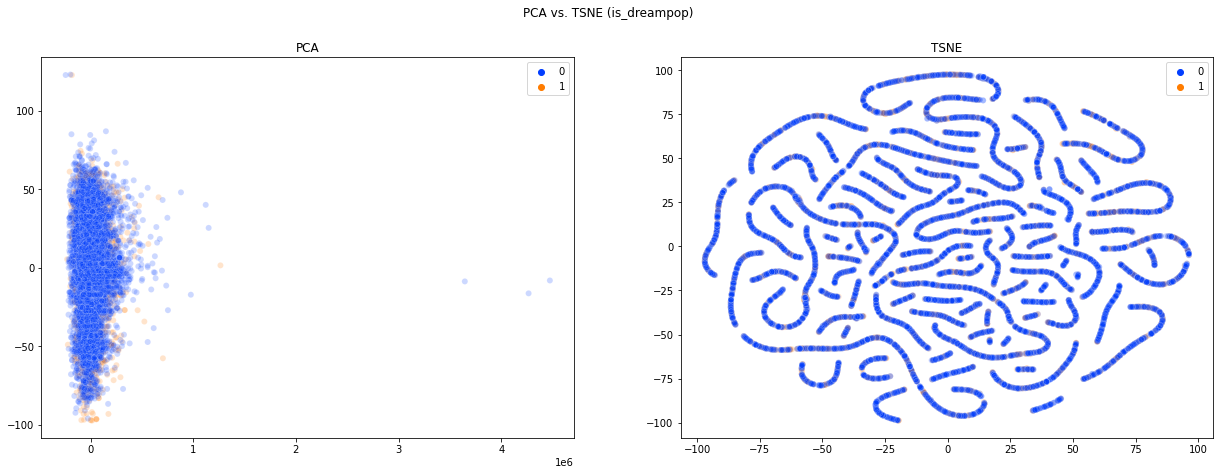

In [9]:
#Graph PCA vs TSNE

fig, axes = plt.subplots(1, 2, figsize=(21, 7))
fig.suptitle('PCA vs. TSNE (is_dreampop)')
axes[0].set_title('PCA')
axes[1].set_title('TSNE')

sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=is_dreampop_int, ax=axes[0], alpha=0.2, palette='bright', legend=True)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=is_dreampop_int, ax=axes[1], alpha=0.2, palette='bright', legend=True)
plt.show()

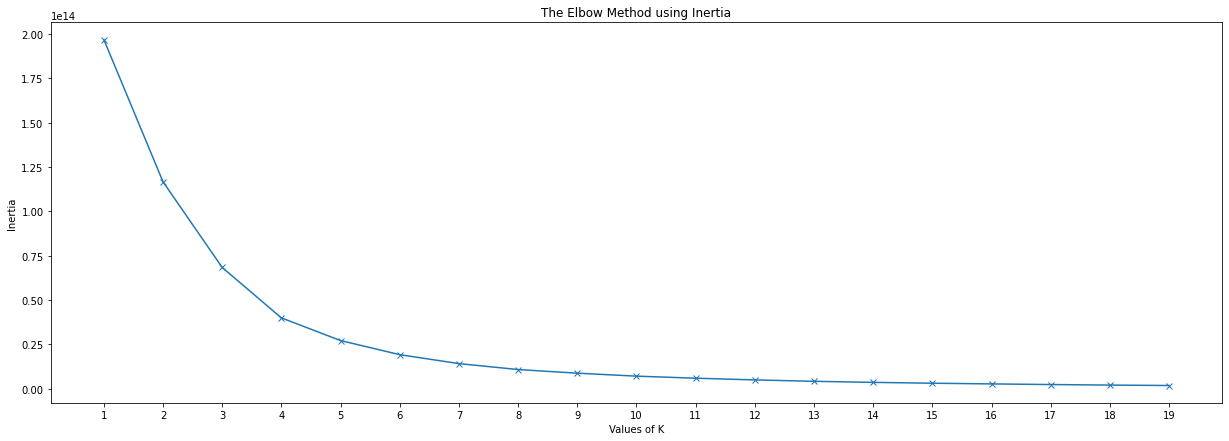

In [10]:
#Elbow Method

inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(cluster_data)
    kmeanModel.fit(cluster_data)
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(cluster_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / cluster_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.figure(figsize=(21, 7))
plt.plot(K, inertias, '-x')
plt.xlabel('Values of K')
plt.xticks(list(K))
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

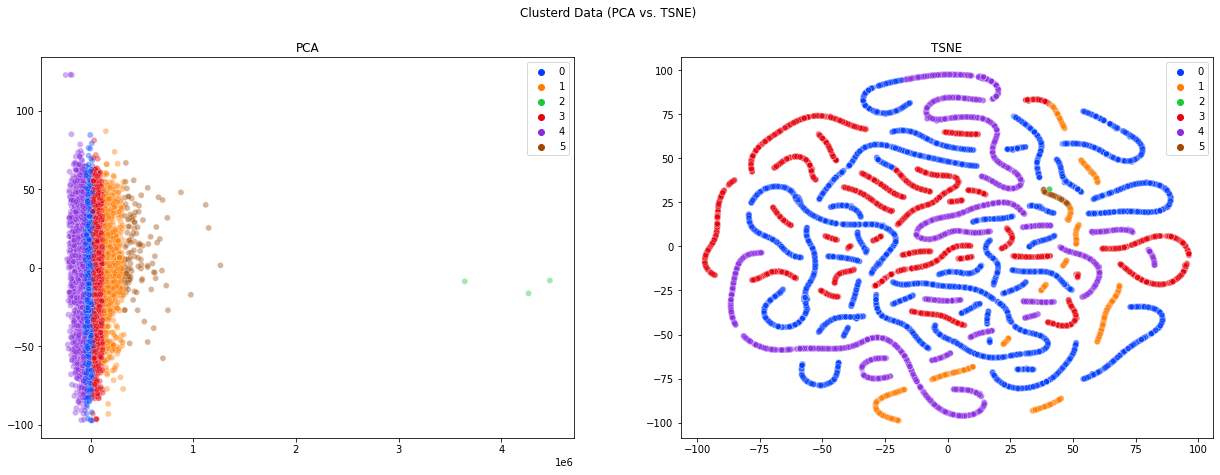

In [11]:
#Cluster Data
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_data)
cluster_labels = kmeans.labels_
clustered_data = data.copy()
clustered_data['cluster'] = cluster_labels.tolist()

fig, axes = plt.subplots(1, 2, figsize=(21, 7))
fig.suptitle('Clusterd Data (PCA vs. TSNE)')
axes[0].set_title('PCA')
axes[1].set_title('TSNE')

sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=cluster_labels, ax=axes[0], alpha=0.4, palette='bright')
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=cluster_labels, ax=axes[1], alpha=0.4, palette='bright')
plt.show()

## Instrumentalness/Speechiness

In [14]:
#Create arrays
cluster_cols = ['speechiness', 'instrumentalness']
cluster_data = data[cluster_cols].to_numpy()
is_dreampop_int = data['is_dreampop'].to_numpy().astype(int)
labels_int = data['genre_id'].to_numpy()
labels_str = data['genre'].to_numpy()

<ipython-input-15-e974f7813ea5>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  sns.scatterplot(x=cluster_data[:,1], y=cluster_data[:,0], hue=is_dreampop_int, ax=plt.axes(), alpha=0.4, palette='bright', legend=True)


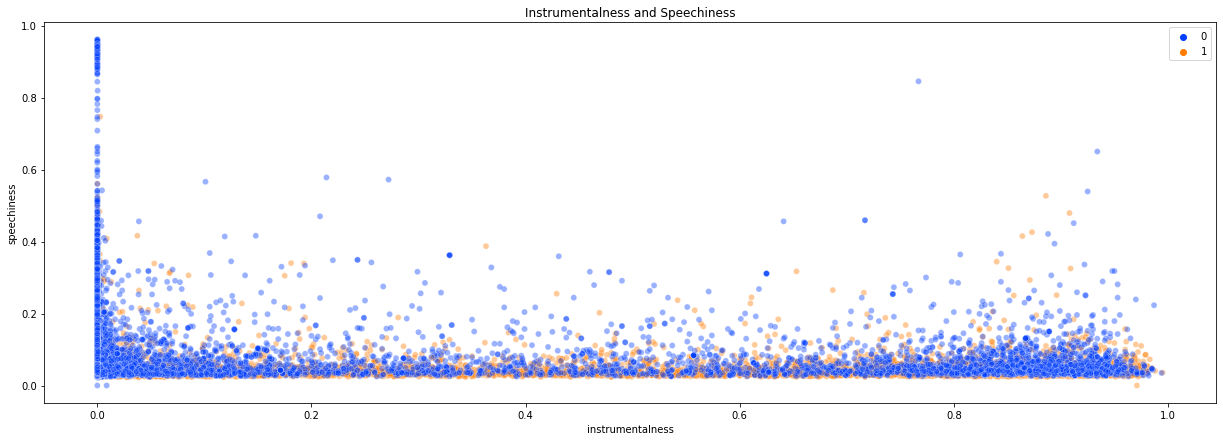

In [15]:
#Graph Instrumentalness and Speechiness

plt.figure(figsize=(21, 7))
plt.title('Instrumentalness and Speechiness')
plt.xlabel('instrumentalness')
plt.ylabel('speechiness')

sns.scatterplot(x=cluster_data[:,1], y=cluster_data[:,0], hue=is_dreampop_int, ax=plt.axes(), alpha=0.4, palette='bright', legend=True)
plt.show()

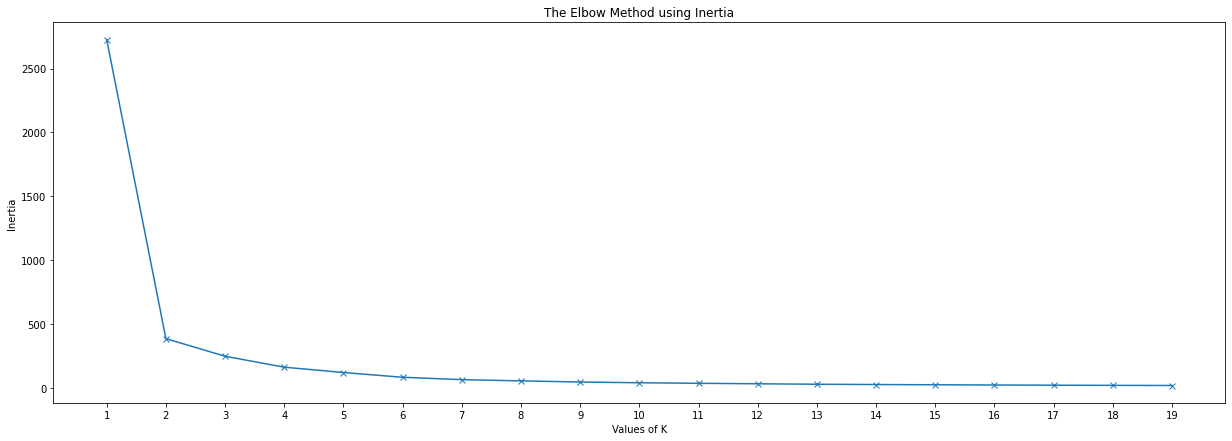

In [16]:
#Elbow Method

inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(cluster_data)
    kmeanModel.fit(cluster_data)
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(cluster_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / cluster_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.figure(figsize=(21, 7))
plt.plot(K, inertias, '-x')
plt.xlabel('Values of K')
plt.xticks(list(K))
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

<ipython-input-19-db0aaa4263c1>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  sns.scatterplot(x=cluster_data[:,1], y=cluster_data[:,0], hue=clustered_data['cluster'], ax=plt.axes(), alpha=0.4, palette='bright', legend=True)


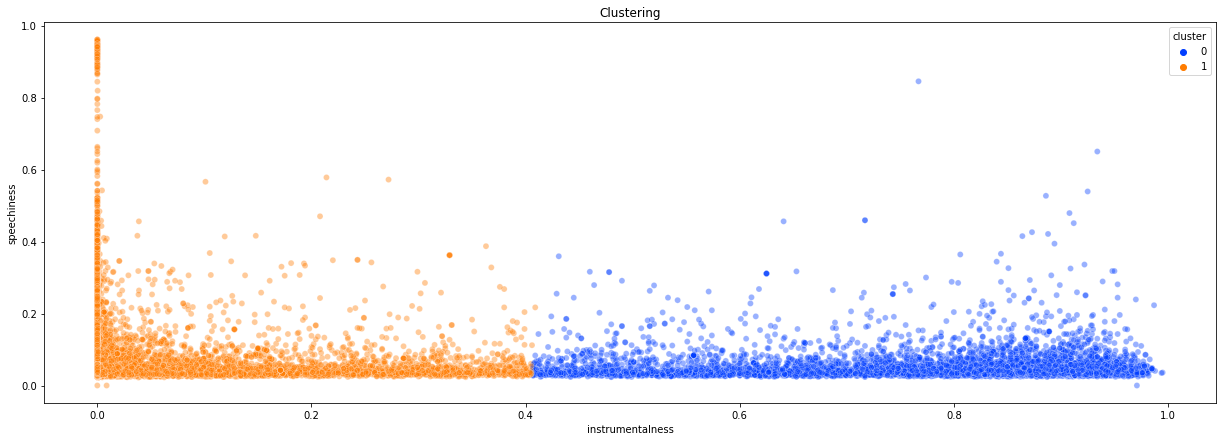

In [19]:
#Cluster Data
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_data)
cluster_labels = kmeans.labels_
clustered_data = data.copy()
clustered_data['cluster'] = cluster_labels.tolist()

plt.figure(figsize=(21, 7))
plt.title('Clustering')
plt.xlabel('instrumentalness')
plt.ylabel('speechiness')

sns.scatterplot(x=cluster_data[:,1], y=cluster_data[:,0], hue=clustered_data['cluster'], ax=plt.axes(), alpha=0.4, palette='bright', legend=True)
plt.show()

In [29]:
clustered_data.groupby(['is_dreampop', 'cluster']).count()[['id']]

id
is_dreampop cluster       
False       0         2434
            1        10092
True        0         3464
            1         4771